In [ ]:
import torch
import torch.nn as nn
import librosa

from lime_deletion_single import lime_explain, deletion_metric
import sys
sys.path.append('/home/woongjae/XAI')
from SSL_aasist.model import Model

/home/woongjae/miniconda3/envs/aasist/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 로드
model_path = "/home/woongjae/XAI/SSL_aasist/Best_LA_model_for_DF.pth"
model = Model(None, device)
model = nn.DataParallel(model).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print("✅ Model loaded:", model_path)

✅ Model loaded: /home/woongjae/XAI/SSL_aasist/Best_LA_model_for_DF.pth


In [3]:
audio_path = "/home/woongjae/XAI/Datasets/PartialSpoof/database/eval/con_wav/CON_E_0033629.wav"

# librosa로 불러오기
waveform, sr = librosa.load(audio_path, sr=16000)
waveform = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0).to(device)

print("✅ Audio loaded:", audio_path)
print("Waveform shape:", waveform.shape)

✅ Audio loaded: /home/woongjae/XAI/Datasets/PartialSpoof/database/eval/con_wav/CON_E_0033629.wav
Waveform shape: torch.Size([1, 36163])


### word-level

/home/woongjae/miniconda3/envs/aasist/lib/python3.8/site-packages/transformers/models/whisper/generation_whisper.py:509: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.
Whisper did not predict an ending timestamp, which can happen if audio i

Total segments: 6
[Baseline] pred=0 (real), score=4.339175


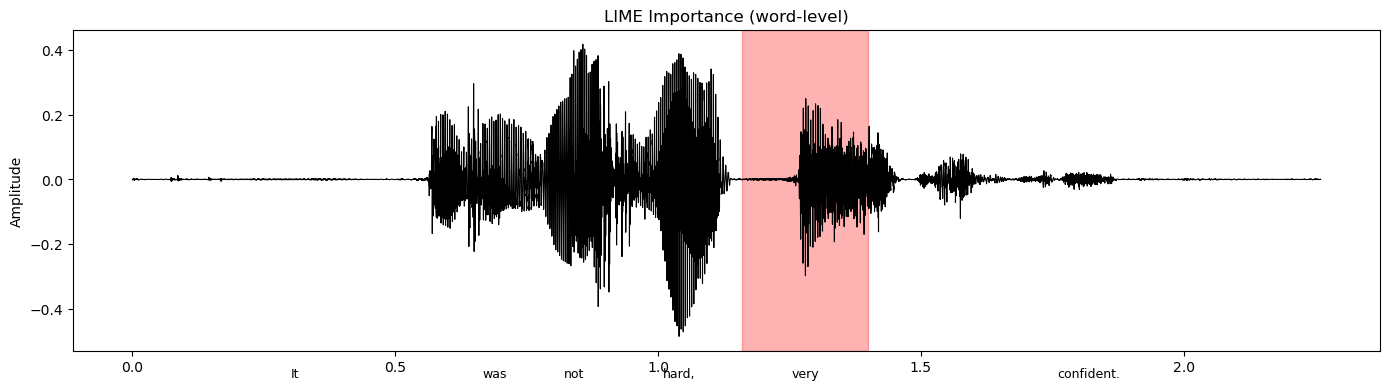

In [5]:
importances, segments, words = lime_explain(
    model, waveform, audio_path=audio_path,
    mode="word", num_samples=200,
    device=device, top_ratio=0.2
)

[Deletion-Binary] target_class=0, baseline=0.9996


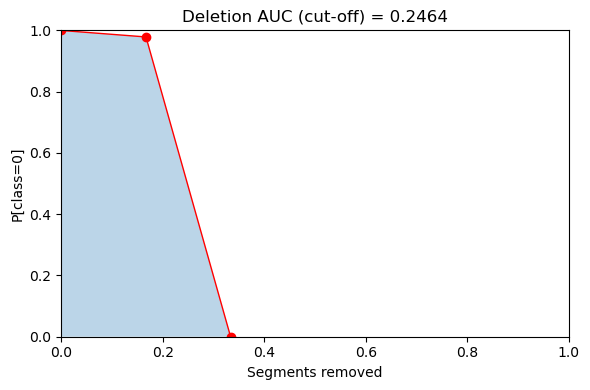

Deletion AUC (cut-off): 0.2464
Stopped at segment index: 2 / 6


In [6]:
ratios, confs, auc_val, stop_idx = deletion_metric(
    model, waveform, segments, importances,
    device="cuda", use_logit=False, stop_threshold=0.05
)

print(f"Deletion AUC (cut-off): {auc_val:.4f}")
print(f"Stopped at segment index: {stop_idx} / {len(segments)}")

Total segments: 12


/home/woongjae/miniconda3/envs/aasist/lib/python3.8/site-packages/torch/nn/modules/conv.py:309: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


[Baseline] pred=0 (real), score=4.339175


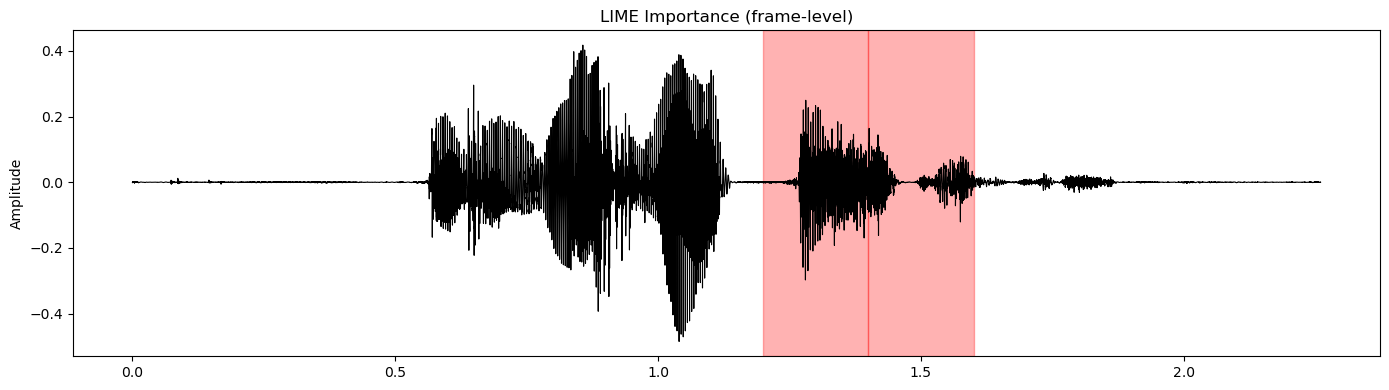

In [4]:
importances, segments, _ = lime_explain(
    model, waveform, audio_path=audio_path,
    mode="frame", frame_ms=200, num_samples=200,
    device=device, top_ratio=0.2
)